In [45]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import greycomatrix, greycoprops
from skimage.io import imread, imshow
from skimage.color import rgb2gray
from sklearn.preprocessing import LabelEncoder
import cv2
import os

## 1. Feature Extraction 

Haralick Features

In [58]:
def extract_haralick_features(grayscale_image, args):
    distances = args['distances']
    angles = args['angles']
    glcm = greycomatrix(grayscale_image, distances, angles)
    features = [
        np.mean(greycoprops(glcm, 'contrast')),
        np.mean(greycoprops(glcm, 'dissimilarity')),
        np.mean(greycoprops(glcm, 'homogeneity')),
        np.mean(greycoprops(glcm, 'energy')),
        np.mean(greycoprops(glcm, 'correlation')),
        np.mean(greycoprops(glcm, 'ASM')),
    ]
    return features

def label_encode(y):
    le = LabelEncoder()
    le.fit(y)
    return (le.transform(y), le.classes_)

def get_dir_contents(path):
    cts = os.listdir(path)
    return [c for c in cts if c[0] != '.']

def get_X_y_vectors(path, feature_extraction_function, args):
    X = []
    y = []
    for label in get_dir_contents(path):
        for file_name in get_dir_contents(path + label + "/"):
            image = cv2.imread(path + label + "/" + file_name, cv2.IMREAD_GRAYSCALE)
            features = feature_extraction_function(image, args)
            X.append(features)
            y.append(label)
    y, classes_ = label_encode(y)
    return (np.array(X), y, classes_)

In [60]:
TRAIN_IMAGES_PATH = 'dataset/train/'
TEST_IMAGES_PATH = 'dataset/test/'

haralick_args = {
    'distances': [1], 
    'angles': [0, np.pi/4, np.pi/2, 3*np.pi/4]
}

X_train, y_train, train_classes_ = get_X_y_vectors(
    TRAIN_IMAGES_PATH, extract_haralick_features, haralick_args
)
X_test, y_test, test_classes_ = get_X_y_vectors(
    TEST_IMAGES_PATH, extract_haralick_features, haralick_args
)


print(f"X_train: {X_train.shape}\ty_train: {y_train.shape}")
print(f"X_test: {X_test.shape}\ty_test: {y_test.shape}")
print(f"Train classes: {train_classes_}\nTest classes: {test_classes_}")

X_train: (800, 6)	y_train: (800,)
X_test: (300, 6)	y_test: (300,)
Train classes: ['coast' 'dead_sargassum' 'sargassum' 'sky' 'water']
Test classes: ['coast' 'dead_sargassum' 'sargassum' 'sky' 'water']


## 2. Model Training

In [70]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

In [111]:
def evaluate(model, X_test, y_true, y_pred, target_names, model_name):
    print(f"----------—-------------—-------------—---{model_name}----------—-------------—-------------—---")
    print(classification_report(y_test, y_true, target_names=target_names))
    plot_confusion_matrix(model, X_test, y_true, display_labels=target_names, cmap=plt.cm.Blues)
    plt.title(f"{model_name} confusion matrix")
    plt.show()

----------—-------------—-------------—---KNN----------—-------------—-------------—---
                precision    recall  f1-score   support

         coast       1.00      1.00      1.00       116
dead_sargassum       1.00      1.00      1.00        45
     sargassum       1.00      1.00      1.00        53
           sky       1.00      1.00      1.00        29
         water       1.00      1.00      1.00        57

      accuracy                           1.00       300
     macro avg       1.00      1.00      1.00       300
  weighted avg       1.00      1.00      1.00       300



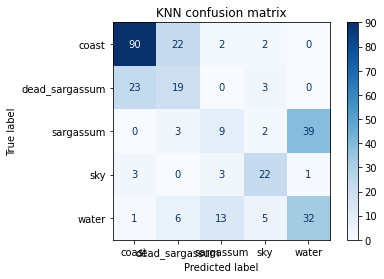

In [112]:
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
evaluate(knn, X_test, y_test, y_pred, test_classes_, "KNN")